# Spotify Dataset Exercise
Aaron Bishop (github@foozbat.net)

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import randint as sp_randint

## Exploratory Data Analysis
Import Spotify dataset and do some initial exploration

In [167]:
df = pd.read_csv("dataset.csv")
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [168]:
print("Dataset shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Number of duplicate rows:", df.duplicated().sum())
print("Number of duplicate tracks:", df['track_id'].duplicated().sum())
print("Columns with non-numeric values:", df.select_dtypes(exclude=['number']).columns.tolist())

Dataset shape: (114000, 21)
Missing values:
 Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64
Number of duplicate rows: 0
Number of duplicate tracks: 24259
Columns with non-numeric values: ['track_id', 'artists', 'album_name', 'track_name', 'explicit', 'track_genre']


In [169]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


#### Initial data pre-processing

In [170]:
# drop null values
df.dropna(inplace=True)

# drop columns with unique identifiers or non-categorical text values
#df2 = df.drop(columns=['track_id', 'track_name', 'album_name','artists'])

# convert non-numeric values to numeric
df['explicit'] = df['explicit'].astype(int)

le = LabelEncoder()

# Encode the 'track_genre' column
df['track_genre'] = le.fit_transform(df['track_genre'])

# get rid of the redundant ID column since it matches the DF ID
df = df.drop(df.columns[0:5], axis=1)
#df.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], axis=1)

df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


#### Check for outliers

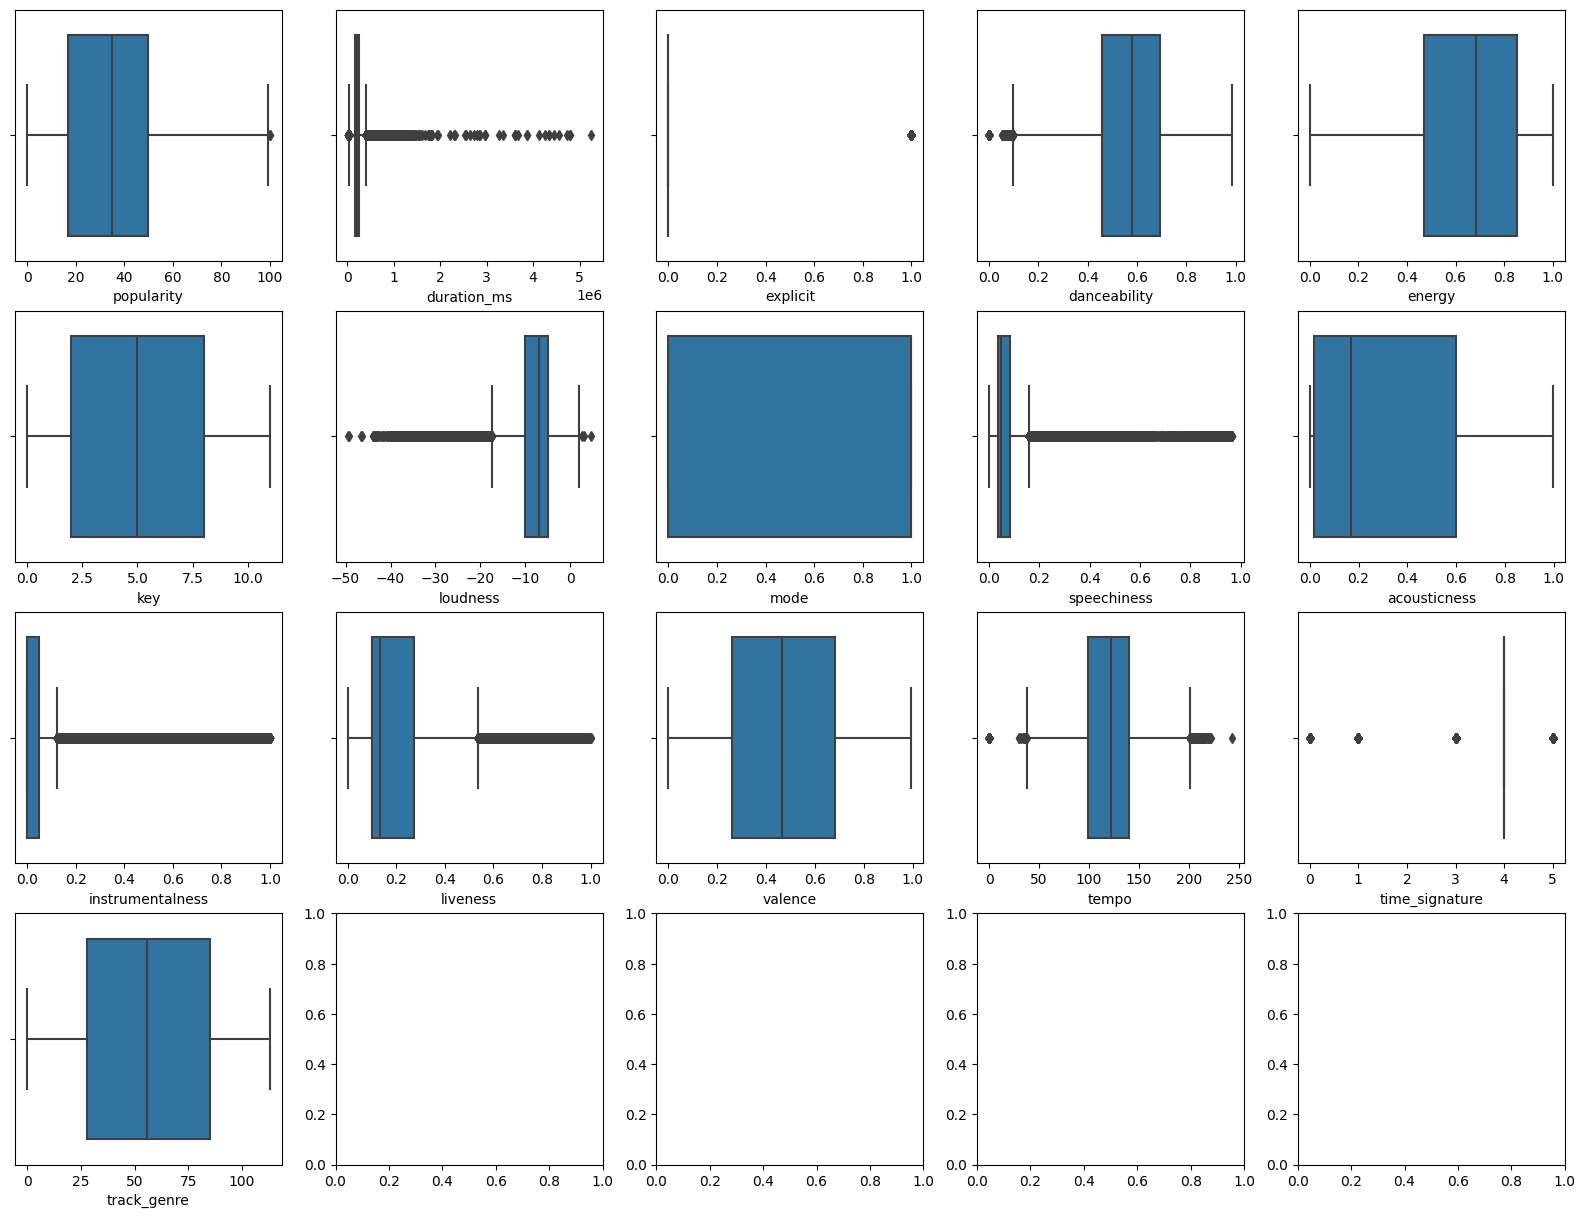

In [171]:
# get the numeric features
features = list(df.columns) #list(df.iloc[:,4:].columns)

fig, axs = plt.subplots(4, 5, figsize=(20, 15))
for i, feature in enumerate(features):
    sns.boxplot(x=df[feature], ax=axs[i//5, i%5])
plt.show()

It looks like time_signature, tempo, danceability, and popularity may have some outliers.  Let's investigate.

In [172]:
z_time_sig = np.abs((df['time_signature'] - df['time_signature'].mean()) / df['time_signature'].std())

print("Non-typical time signatures:")
print("0/4 Time: ", len(df[df['time_signature'] == 0]))
print("1/4 Time: ", len(df[df['time_signature'] == 1]))
print("Z-Score Outliers (threshold=3): ", len(df[z_time_sig > 3]))
print()

df[df['time_signature'] == 0].head()

Non-typical time signatures:
0/4 Time:  163
1/4 Time:  973
Z-Score Outliers (threshold=3):  1136



,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
2926,44,213198,0,0.442,0.5670,8,-6.346,0,0.0516,0.238,0.000325,0.0852,0.639,138.616,0,2
4131,64,151506,0,0.000,0.0362,0,-22.519,0,0.0000,0.994,0.940000,0.0958,0.000,0.000,0,4
4379,55,73266,0,0.000,0.0445,0,-26.440,0,0.0000,0.972,0.972000,0.0873,0.000,0.000,0,4
4664,53,68493,0,0.000,0.0323,2,-23.636,0,0.0000,0.994,0.973000,0.0922,0.000,0.000,0,4
26910,18,203705,0,0.329,0.0607,9,-28.310,1,0.0507,0.994,0.880000,0.0858,0.421,93.948,0,26


In [173]:
df[df['popularity'] == 100]

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
20001,100,156943,0,0.714,0.472,2,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,20
81051,100,156943,0,0.714,0.472,2,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,80


Some instrumental, background, and foriegn music may make use of non-traditional time signatures or have no time signature at all.  The data supports this observation, so we won't count these as outliers.  Danceability is subjective and tempo can vary widely, so I don't consider those outliers.  The song with popularity=100 was apparently a chart topper upon researching, so again probably not an outlier.

### Correlation

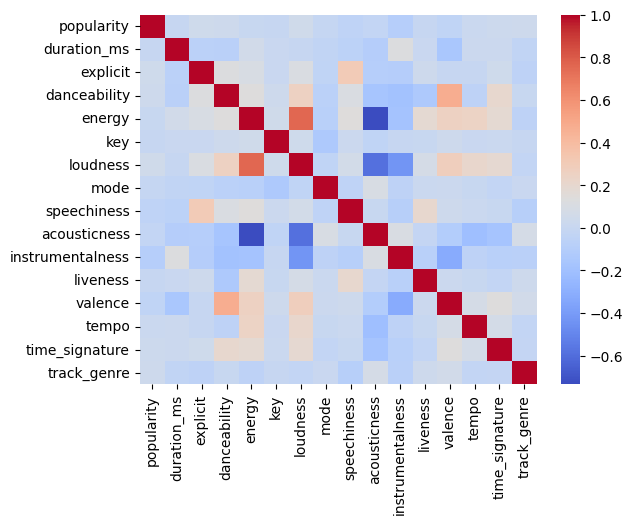

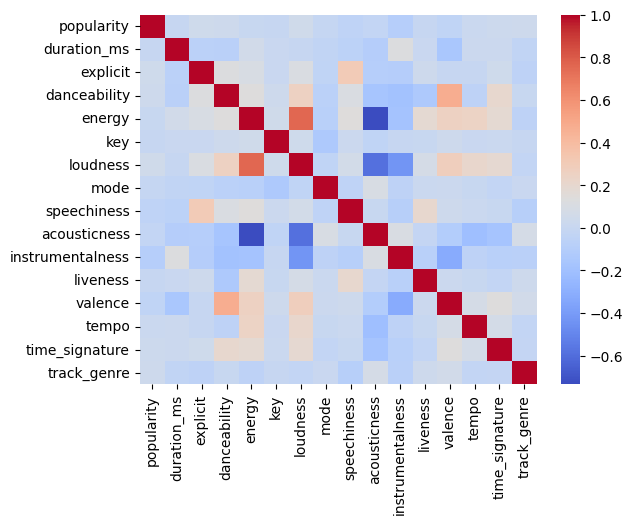

In [174]:
# correlate numeric values using min-max scaling
scaled = (df - df.min()) / (df.max() - df.min())

sns.heatmap(scaled.corr(), cmap='coolwarm')
plt.show()

sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

In both scaled and non-scaled correlations, popularity is not strongly associated with any particular feature.  Though, based off color coding it seems that instrumentalness and speechiness have the strongest correlation, followed by duration_ms, energy, key, mode, acousticness, liveness, and valence.  The remaining features had the weakest correlation to popularity.

### Visualize Strongest Features

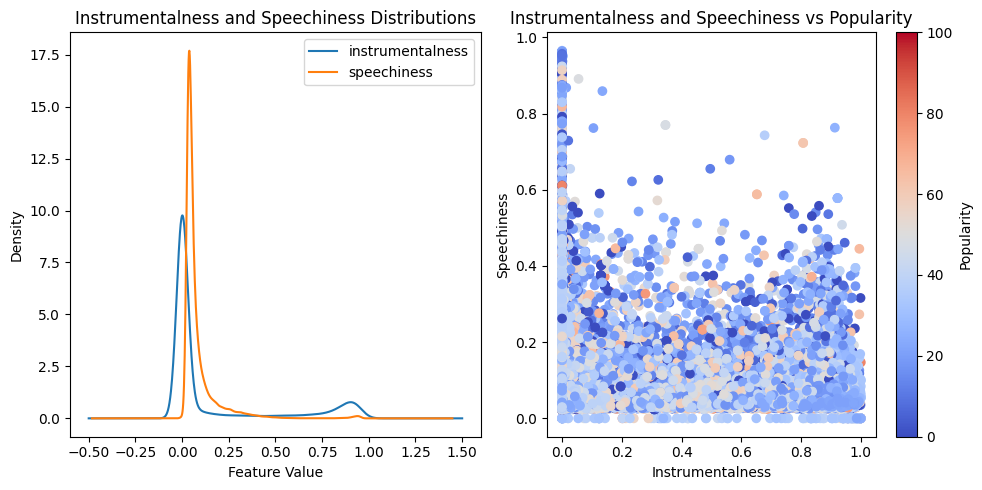

In [175]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the distributions of instrumentalness and speechiness
df[['instrumentalness', 'speechiness']].plot(kind='kde', ax=ax1)
ax1.set_title('Instrumentalness and Speechiness Distributions')
ax1.set_xlabel('Feature Value')
ax1.set_ylabel('Density')

# Plot the relationship between instrumentalness, speechiness, and popularity
scatter = ax2.scatter(df['instrumentalness'], df['speechiness'], c=df['popularity'], cmap='coolwarm')
ax2.set_title('Instrumentalness and Speechiness vs Popularity')
ax2.set_xlabel('Instrumentalness')
ax2.set_ylabel('Speechiness')
cbar = plt.colorbar(scatter)
cbar.set_label('Popularity')

plt.tight_layout()
plt.show()

## Principal Component Analysis

In [176]:
def pca(data, features):
    pca = PCA(n_components=2)
    pca.fit(data[features])
    transformed = pca.transform(data[features])

    # Plot the transformed data
    plt.scatter(transformed[:, 0], transformed[:, 1], c=data['popularity'], cmap='plasma')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA')
    plt.show()

    print(pca.explained_variance_ratio_)

    return pd.DataFrame(data=transformed, columns=['PC1', 'PC2'])

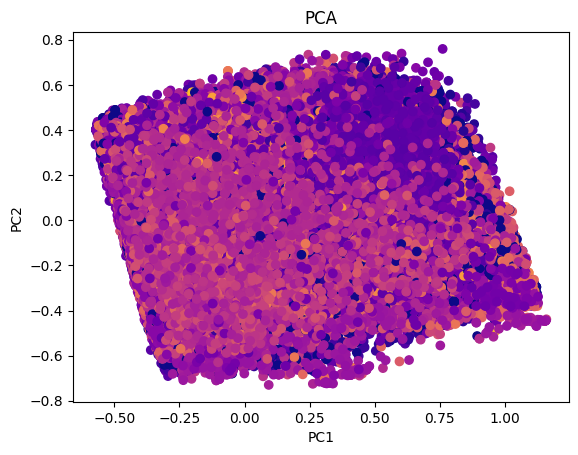

[0.55536798 0.2514782 ]


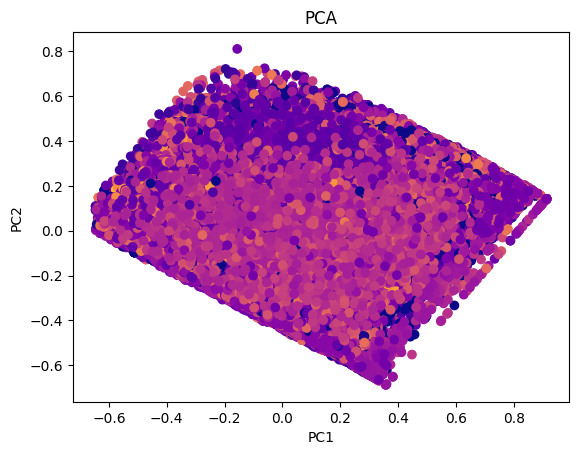

[0.55529201 0.31677051]


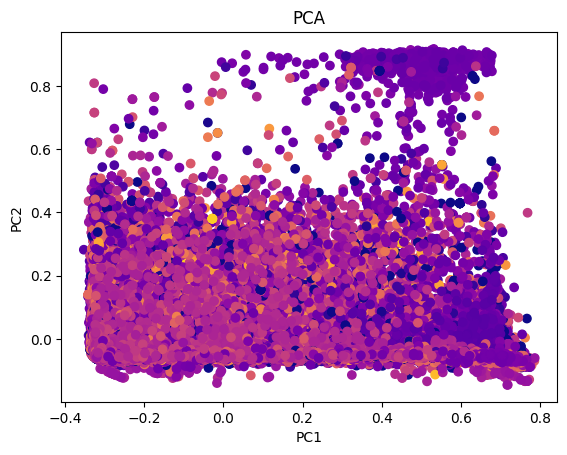

[0.86760168 0.09127323]


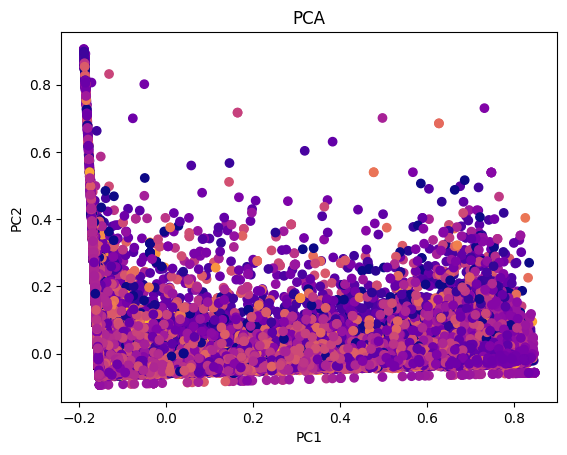

[0.88968743 0.11031257]


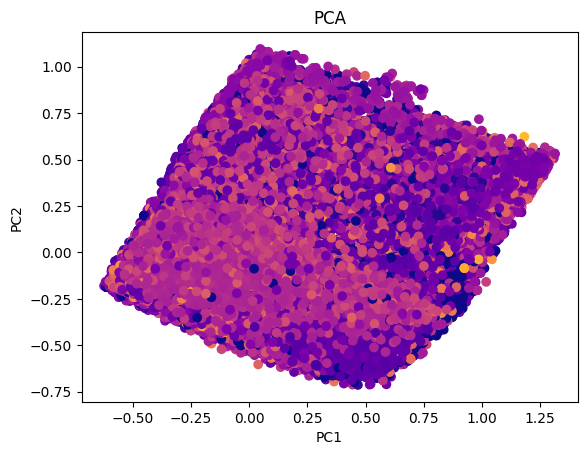

[0.40131027 0.24968644]


In [177]:
pca(scaled, ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'valence'])
pca(scaled, ['valence', 'energy', 'danceability'])
pca(scaled, ['speechiness', 'loudness', 'acousticness'])
pca(scaled, ['instrumentalness', 'speechiness'])
pca_data = pca(scaled, ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'])

## Clustering

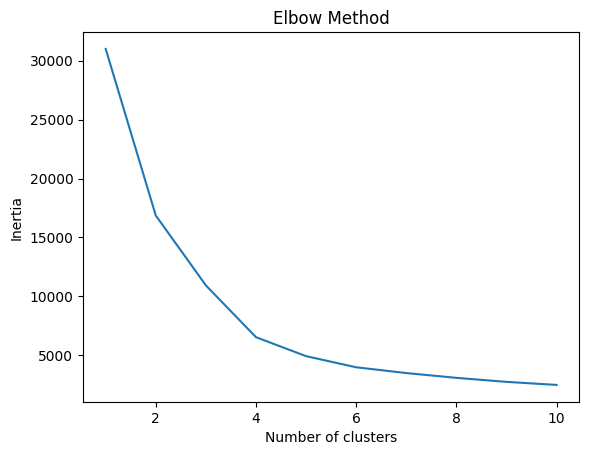

In [178]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    inertia = []

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_data)
        inertia.append(kmeans.inertia_)

    sns.lineplot(x=range(1, 11), y=inertia)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

Based on the elbow method, it looks like 3 clusters is optimal.  Now, cluster the data using K-Means clustering and visualize.

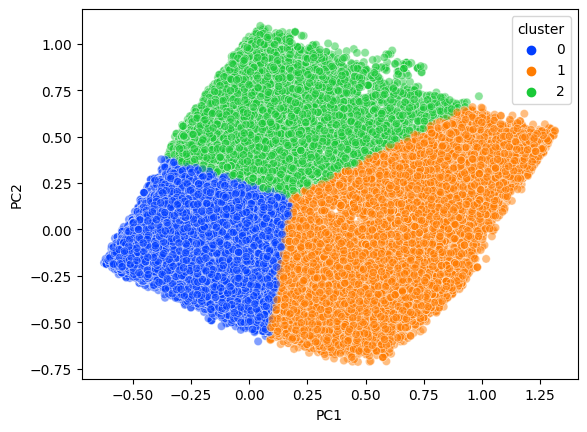

In [179]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(pca_data)
    pca_data['cluster'] = kmeans.labels_

    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='cluster', palette='bright', alpha=0.5)
    plt.show()

## Model Training

First, select out 30% of the data as a test set.  We'll be using the featured identified during PCA as our training data and popularity as the target.

In [190]:
X = scaled[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
Y = scaled['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Train three models and evaluate performance

In [191]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print('Linear Regression R-squared: {:.2f}'.format(lr_r2))
print('Linear Regression RMSE: {:.2f}'.format(lr_rmse))

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_r2 = r2_score(y_test, y_pred_dt)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print('Decision Tree Regressor R-squared: {:.2f}'.format(dt_r2))
print('Decision Tree Regressor RMSE: {:.2f}'.format(dt_rmse))

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print('Random Forest Regressor R-squared: {:.2f}'.format(rf_r2))
print('Random Forest Regressor RMSE: {:.2f}'.format(rf_rmse))

Linear Regression R-squared: 0.02
Linear Regression RMSE: 0.22
Decision Tree Regressor R-squared: 0.05
Decision Tree Regressor RMSE: 0.22
Random Forest Regressor R-squared: 0.50
Random Forest Regressor RMSE: 0.16


While none of the models produced optimal results, it appears that the Random Forest Regressor performed the best.  All models performed marginally better with normalized data.

## Hyperparameter Tuning
We'll be comparing tuning algorithms to see which one has the best performance: GridSearchCV and RandomizedSearchCV

In [193]:
param_grid = {'max_depth': [2, 4, 6, 8],
              'min_samples_split': [2, 4, 6, 8],
              'min_samples_leaf': [1, 3, 5, 7],
              'max_features': ['sqrt', 'log2']}

param_dist = {'max_depth': sp_randint(1, 10),
              'min_samples_split': sp_randint(2, 20),
              'min_samples_leaf': sp_randint(1, 20),
              'max_features': sp_randint(1, X_train.shape[1])}

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
grid_search.fit(X_train, y_train)
random_search.fit(X_train, y_train)

grid_best_params = grid_search.best_params_
random_best_params = random_search.best_params_
grid_best_model = grid_search.best_estimator_
random_best_model = random_search.best_estimator_

grid_predict = grid_best_model.predict(X_test)
random_predict = random_best_model.predict(X_test)

## Evaluation

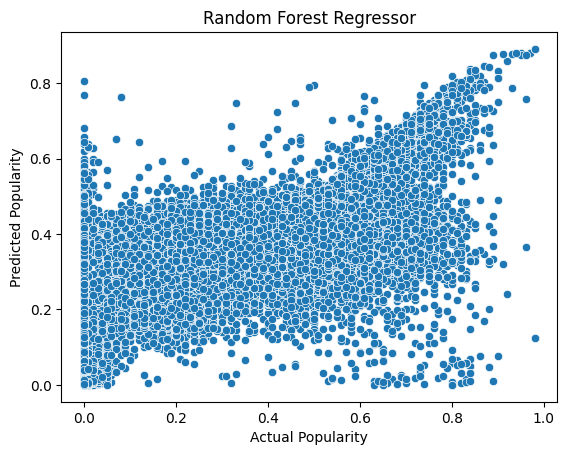

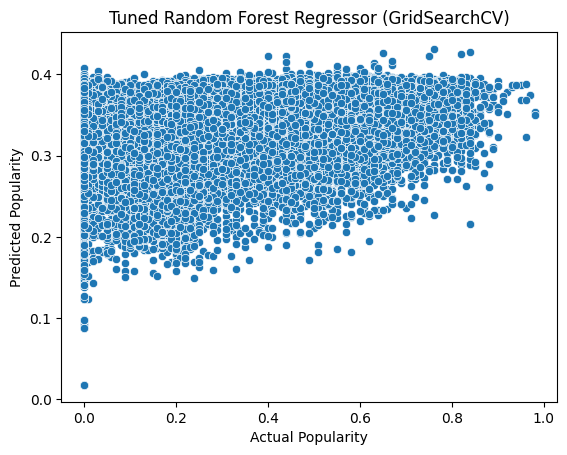

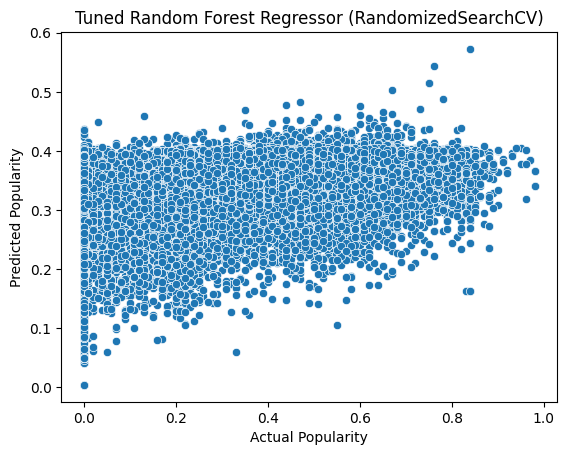

GridSearchCV best hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6}
RandomizedSearchCV best hyperparameters: {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 13}
GridSearchCV R2 on test set: 0.09
GridSearchCV RMSE on test set: 0.21
RandomizedSearchCV R2 on test set: 0.11
RandomizedSearchCV RMSE on test set: 0.21


In [197]:
grid_r2 = r2_score(y_test, grid_predict)
grid_rmse = mean_squared_error(y_test, grid_predict, squared=False)
random_r2 = r2_score(y_test, random_predict)
random_rmse = mean_squared_error(y_test, random_predict, squared=False)

sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Random Forest Regressor')
plt.show()

sns.scatterplot(x=y_test, y=grid_predict)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Tuned Random Forest Regressor (GridSearchCV)')
plt.show()

sns.scatterplot(x=y_test, y=random_predict)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Tuned Random Forest Regressor (RandomizedSearchCV)')
plt.show()

print('GridSearchCV best hyperparameters:', grid_best_params)
print('RandomizedSearchCV best hyperparameters:', random_best_params)
print('GridSearchCV R2 on test set: {:.2f}'.format(grid_r2))
print('GridSearchCV RMSE on test set: {:.2f}'.format(grid_rmse))
print('RandomizedSearchCV R2 on test set: {:.2f}'.format(random_r2))
print('RandomizedSearchCV RMSE on test set: {:.2f}'.format(random_rmse))